In [1]:
import numpy as np
import vtk
from vtk.util import numpy_support
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [2]:
def rotations24(polycube):
    # imagine shape is pointing in axis 0 (up)

    # 4 rotations about axis 0
    yield from rotations4(polycube, 0)

    # rotate 180 about axis 1, now shape is pointing down in axis 0
    # 4 rotations about axis 0
    yield from rotations4(rot90(polycube, 2, axis=1), 0)

    # rotate 90 or 270 about axis 1, now shape is pointing in axis 2
    # 8 rotations about axis 2
    yield from rotations4(rot90(polycube, axis=1), 2)
    yield from rotations4(rot90(polycube, -1, axis=1), 2)

    # rotate about axis 2, now shape is pointing in axis 1
    # 8 rotations about axis 1
    yield from rotations4(rot90(polycube, axis=2), 1)
    yield from rotations4(rot90(polycube, -1, axis=2), 1)

def rotations4(polycube, axis):
    """List the four rotations of the given cube about the given axis."""
    for i in range(4):
        yield rot90(polycube, i, axis)
        
def rot90(m, k=1, axis=2):
    """Rotate an array k*90 degrees in the counter-clockwise direction around the given axis"""
    m = np.swapaxes(m, 2, axis)
    m = np.rot90(m, k)
    m = np.swapaxes(m, 2, axis)
    return m

In [3]:
# Import Vtk file
reader = vtk.vtkUnstructuredGridReader()
reader.SetFileName("results_24.vtk")
reader.ReadAllScalarsOn()
reader.ReadAllVectorsOn()
reader.Update()

# Get the coordinates of the points
nodes_vtk_array = reader.GetOutput().GetPoints().GetData() # get position of each data point

# Extract force and displacement data from VTK file
forceVTK = reader.GetOutput().GetPointData().GetArray(0)
displacementVTK = reader.GetOutput().GetPointData().GetArray(1)

# get x, y, z grid points
nodes_numpy_array = numpy_support.vtk_to_numpy(nodes_vtk_array)
x,y,z = nodes_numpy_array[:,0] , nodes_numpy_array[:,1] , nodes_numpy_array[:,2]

# Convert from VTK to numpy
displacement_numpy_array = numpy_support.vtk_to_numpy(displacementVTK)
force_numpy_array = numpy_support.vtk_to_numpy(forceVTK)

# Find value range in which to interpolate
npts = 64
xmin, xmax = min(x), max(x)
ymin, ymax = min(y), max(y)
zmin, zmax = min(z), max(z)

# Define grid points per dimension (structured)
xi = np.linspace(xmin, xmax, npts)
yi = np.linspace(ymin, ymax, npts)
zi = np.linspace(zmin, zmax, npts)

# Assemble grid
ar_len = len(xi)*len(yi)*len(zi)
X = np.arange(ar_len, dtype = float)
Y = np.arange(ar_len, dtype = float)
Z = np.arange(ar_len, dtype = float)
l = 0
for i in range(0,len(xi)):
    for j in range(0,len(yi)):
        for k in range(0,len(zi)):
            X[l] = xi[i]
            Y[l] = yi[j]
            Z[l] = zi[k]
            l=l+1

# interpolate in grid
displacement_array = griddata((x, y, z), displacementVTK, (X, Y, Z))
force_array = griddata((x, y, z), forceVTK, (X, Y, Z))

# reshape
displacement_array = displacement_array.reshape((64,64,64,3))
force_array = force_array.reshape((64,64,64,3))

print("done")

done


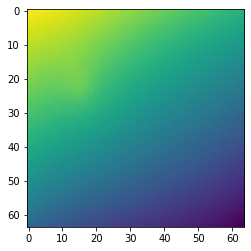

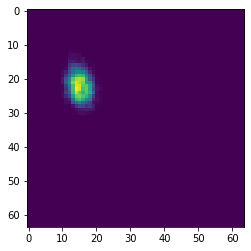

In [4]:
# test if interpolation worked
disp_test = displacement_array.copy()
disp_test = disp_test.reshape((64,64,64,3))
plt.imshow(disp_test[:,:,35,2])
plt.show()

force_test = force_array.copy()
force_test = force_test.reshape((64,64,64,3))
plt.imshow(force_test[:,:,35,2])
plt.show()

In [5]:
displacementList = rotations24(displacement_array)
displacementList = list(displacementList)
print('No. of distinct rotations for Displacement vector:', len(set(str(x) for x in rotations24(displacement_array))))
displacement = np.asarray(displacementList)

forceList = rotations24(force_array)
forceList = list(forceList)
print('No. of distinct rotations for Force vector:', len(set(str(x) for x in rotations24(force_array))))
force = np.asarray(forceList)

No. of distinct rotations for Displacement vector: 24
No. of distinct rotations for Force vector: 24


In [270]:
#np.save('forcetest12.npy', force)
#np.save('disptest12.npy', displacement)